# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [3]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


### 2. Preprocessing the Data

**2.1. Dropping Records with missing values**

In [6]:
# handling NaN records in genre_column
df = df.dropna(axis=0, subset=['Genre'])

**2.2. Handling `Platform` column**

In [7]:
df.Platform.unique()

array(['PSP', '2600', 'XB', 'X360', 'DS', 'PS2', 'Wii', 'PS3', '3DS',
       'PS', 'XOne', 'SNES', 'WiiU', 'GBA', 'PS4', 'PC', 'PSV', 'SAT',
       'GC', 'NES', 'N64', 'GEN', 'PCFX', 'GB', 'DC', 'TG16', 'NG', 'SCD',
       'WS', '3DO', 'GG'], dtype=object)

In [8]:
# check Platform_column for main platforms and create interim columns
df['Nintendo']    = df['Platform'].str.contains('DS', regex=True)
df['Playstation'] = df['Platform'].str.contains('PS', regex=True)
df['X_Box']       = df['Platform'].str.contains('X(\d|\w)', regex=True)
df['Wii']         = df['Platform'].str.contains('Wii', regex=True)
df['PC']          = df['Platform'].str.contains('PC', regex=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [9]:
# define function ...
def label_platform(row):
    if row['Nintendo'] == True:
        return 'Nintendo'
    if row['Playstation'] == True:
        return 'Playstation'
    if row['X_Box'] == True:
        return 'X_Box'
    if row['Wii'] == True:
        return 'Wii'
    if row['PC'] == True:
        return 'PC'
    return 'Other'

# ... and apply this function for creating a new column
df['platform_groups'] = df.apply(lambda row: label_platform(row), axis=1)

# dropping interim columns
df = df.drop(['Platform', 'Nintendo', 'Playstation', 'X_Box', 'Wii', 'PC'], axis=1)

df.head()

,Id,NA_Sales,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,platform_groups
0,0,0.00,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E,Playstation
1,1,0.72,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN,Other
2,2,0.11,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN,X_Box
3,3,0.15,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T,X_Box
4,4,0.00,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN,Nintendo


**2.3. Handling NaN's in `Critic_Score`**

In [10]:
# How many NaN's are we up against?
round(df['Critic_Score'].isna().sum()/len(df), 3)

0.513

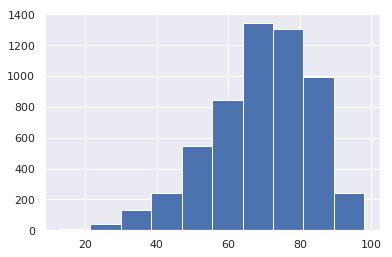

In [11]:
df.Critic_Score.hist();

In [12]:
df.Critic_Score.describe()

count    5697.000000
mean       68.909602
std        14.052323
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

... using regression ...

In [13]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'JP_Sales', 'Critic_Score']]

# split datasets
train_data = sub_df[sub_df['Critic_Score'].notnull()]
test_data  = sub_df[sub_df['Critic_Score'].isnull()]

# define X
X_train = train_data.drop('Critic_Score', axis=1)
X_test  = test_data.drop('Critic_Score', axis=1)

# define y
y_train = train_data['Critic_Score']

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5697, 3)
Shape of Test Data:     (6004, 3)

Shape of X_train: (5697, 2)
Shape of X_test: (6004, 2)

Shape of y_train: (5697,)


In [14]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# making predictions
y_test = linreg.predict(X_test)

In [15]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['Critic_Score']
print(y_test.shape)
y_test.head(2)

(6004, 1)


,Critic_Score
0,69.780193
1,67.982414


In [16]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(6004, 2)


,NA_Sales,JP_Sales
1,0.72,0.0
2,0.11,0.0


In [17]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)
test_data.head(2)

,NA_Sales,JP_Sales,Critic_Score
1,0.72,0.0,69.780193
2,0.11,0.0,67.982414


In [18]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11701, 3)


,NA_Sales,JP_Sales,Critic_Score
1,0.72,0.0,69.780193
2,0.11,0.0,67.982414


In [19]:
# drop duplicate columns in original dataframe before concatening 
df.drop(['NA_Sales', 'JP_Sales', 'Critic_Score'], axis=1, inplace=True)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11701, 13)


,NA_Sales,JP_Sales,Critic_Score,Id,Year_of_Release,Genre,Publisher,Critic_Count,User_Score,User_Count,Developer,Rating,platform_groups
0,0.00,0.06,81.000000,0,2008.0,Misc,Sony Computer Entertainment,49.0,8.3,62.0,SCE Japan Studio,E,Playstation
1,0.72,0.00,69.780193,1,1982.0,Shooter,Atari,NaN,NaN,NaN,NaN,NaN,Other


In [20]:
df['Critic_Score'].isna().sum()

0

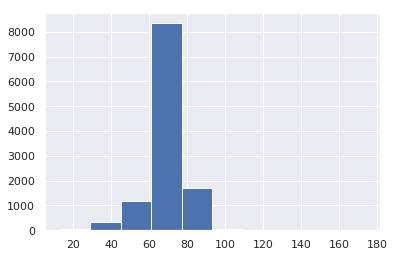

In [21]:
df.Critic_Score.hist();

In [22]:
df.Critic_Score.describe()

count    11701.000000
mean        68.681930
std         10.000410
min         13.000000
25%         67.687571
50%         68.000000
75%         71.401142
max        173.347733
Name: Critic_Score, dtype: float64

In [23]:
df = df.drop(df[(df['Critic_Score'] > 98.) ].index, axis=0)

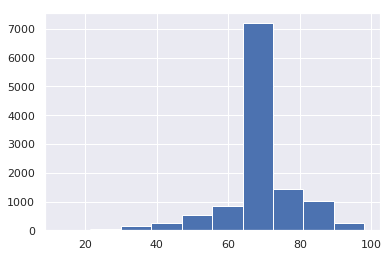

In [24]:
df.Critic_Score.hist();

In [25]:
df.Critic_Score.describe()

count    11693.000000
mean        68.645668
std          9.887201
min         13.000000
25%         67.687571
50%         68.000000
75%         71.369181
max         98.000000
Name: Critic_Score, dtype: float64

**2.4. Handling NaN's in `User_Score`**

In [26]:
# How many NaN's are we up against?
round(df['User_Score'].isna().sum()/len(df), 3)

0.4

In [27]:
df['User_Score'].unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [28]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.User_Score.describe()

count    5332.000000
mean        7.125075
std         1.491034
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

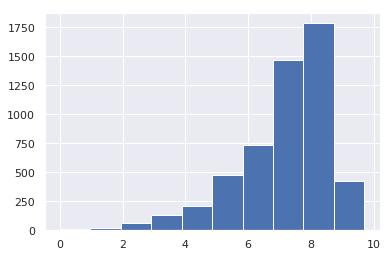

In [29]:
df.User_Score.hist();

In [30]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'JP_Sales', 'User_Score']]

# split datasets
train_data = sub_df[sub_df['User_Score'].notnull()]
test_data  = sub_df[sub_df['User_Score'].isnull()]

# define X
X_train = train_data.drop('User_Score', axis=1)
X_test  = test_data.drop('User_Score', axis=1)

# define y
y_train = train_data['User_Score']

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5332, 3)
Shape of Test Data:     (6361, 3)

Shape of X_train: (5332, 2)
Shape of X_test: (6361, 2)

Shape of y_train: (5332,)


In [31]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# making predictions
y_test = linreg.predict(X_test)

In [34]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['User_Score']
print(y_test.shape)
y_test.head(2)

(6361, 1)


,User_Score
0,7.103646
1,7.077245


In [35]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(6361, 2)


,NA_Sales,JP_Sales
1,0.72,0.0
2,0.11,0.0


In [36]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)

In [37]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11693, 3)


,NA_Sales,JP_Sales,User_Score
1,0.72,0.0,7.103646
2,0.11,0.0,7.077245


In [38]:
sub_df_new['User_Score'].isna().sum()

0

In [39]:
# drop duplicate columns in original dataframe before concatening 
df = df.drop(['NA_Sales', 'JP_Sales', 'User_Score'], axis=1)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11693, 13)


,NA_Sales,JP_Sales,User_Score,Critic_Score,Id,Year_of_Release,Genre,Publisher,Critic_Count,User_Count,Developer,Rating,platform_groups
0,0.00,0.06,8.300000,81.000000,0,2008.0,Misc,Sony Computer Entertainment,49.0,62.0,SCE Japan Studio,E,Playstation
1,0.72,0.00,7.103646,69.780193,1,1982.0,Shooter,Atari,NaN,NaN,NaN,NaN,Other


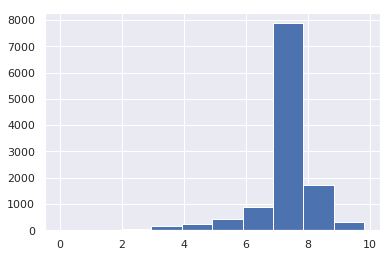

In [40]:
df.User_Score.hist();

In [41]:
df.User_Score.describe()

count    11693.000000
mean         7.127118
std          1.014122
min          0.000000
25%          7.073783
50%          7.089452
75%          7.423137
max          9.826803
Name: User_Score, dtype: float64

**2.5. Dropping Unnecessary Columns**

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11693 entries, 0 to 11702
Data columns (total 13 columns):
NA_Sales           11693 non-null float64
JP_Sales           11693 non-null float64
User_Score         11693 non-null float64
Critic_Score       11693 non-null float64
Id                 11693 non-null int64
Year_of_Release    11510 non-null float64
Genre              11693 non-null object
Publisher          11654 non-null object
Critic_Count       5697 non-null float64
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
platform_groups    11693 non-null object
dtypes: float64(7), int64(1), object(5)
memory usage: 1.2+ MB


In [43]:
# dropping columns
df = df.drop(axis=1, columns=['Id', 'Year_of_Release', 'Genre', 'Publisher', 
                              'Critic_Count', 'User_Count', 'Developer', 'Rating'])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11693 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales           11693 non-null float64
JP_Sales           11693 non-null float64
User_Score         11693 non-null float64
Critic_Score       11693 non-null float64
platform_groups    11693 non-null object
dtypes: float64(4), object(1)
memory usage: 548.1+ KB


## 3. Machine Learning

*Preparing Target & Features*

In [45]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [46]:
# convert string values in genre column into categorical values
#df['Genre'] = df['Genre'].astype('category')
df['platform_groups'] = df['platform_groups'].astype('category')

In [47]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [53]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [54]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


*XGBoost*

In [55]:
# create a baseline
booster = xgb.XGBRegressor()

In [58]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


In [59]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, 
                           max_depth=7, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [60]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.4527
r2: 0.5408
